In [36]:
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
# axial = True
axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# a, b = (1, 1)
(a, b) = (3, 1)

# predict the buckling load factor (BLF)
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_load_factor=}")

pred_load_factor=31.633294000320518


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


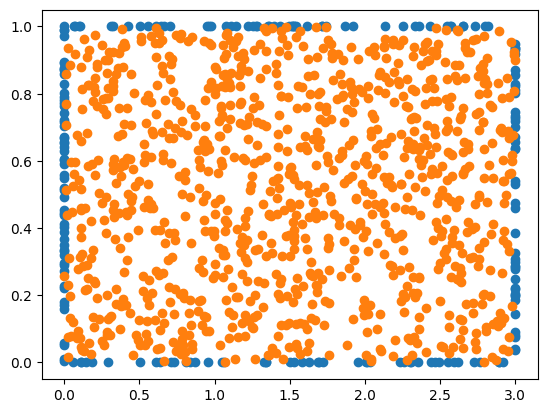

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

num_domain = 10000
num_test = 500

DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

# generate boundary domain points
N_b = 100
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:1000,0], x_train[:1000,1]) # only show 1000 of the points
plt.show()

In [38]:
from tensorflow.keras.initializers import HeNormal

# now start building the tensorflow model
n_inputs = 2
n_outputs = 1
hidden_units = [50, 50, 50]
# activation = 'tanh'
activation = 'relu'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))

null_init = None
he_init = HeNormal() # not great because results in large init BC loss
glorot_init = tf.keras.initializers.GlorotUniform
zero_init = tf.keras.initializers.Zeros()

for units in hidden_units:
  model.add(tf.keras.layers.Dense(units=units, activation=activation, kernel_initializer=he_init, bias_initializer=zero_init))
  # debug : add dropout layers?
  model.add(tf.keras.layers.Dropout(0.4))

# last_activation = 'tanh' # for normalized output since eigenmode
last_activation = None 
model.add(tf.keras.layers.Dense(units=n_outputs, activation=last_activation, kernel_initializer=he_init, bias_initializer=zero_init))
model.summary()

# also add lambda the eigenvalue trainable parameter to update
guess = pred_load_factor # cheat guess first
lambda_var = model.add_weight(name="lambda_var", initializer=tf.keras.initializers.Constant(guess), trainable=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,301 (20.71 KB)

 Trainable params: 5,301 (20.71 KB)

 Non-trainable params: 0 (0.00 B)

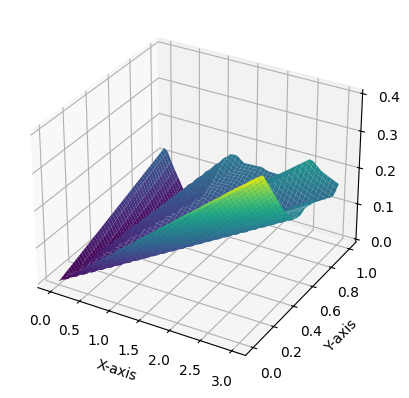

In [39]:
# plot the initial buckling mode prediction
import matplotlib.pyplot as plt
import numpy as np

def plot_mode(n=50):
    n = 50
    x_vec = np.linspace(0, a, n)
    y_vec = np.linspace(0, b, n)
    X, Y = np.meshgrid(x_vec, y_vec)
    x_flat = np.reshape(X, newshape=(n*n,1))
    y_flat = np.reshape(Y, newshape=(n*n,1))
    grid_inputs = np.concatenate([x_flat, y_flat], axis=1)
    w = model(grid_inputs)
    W = np.reshape(w, newshape=(n,n))

    # plt.figure(figsize=(8, 6))
    # colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, W, cmap='viridis')

    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.title("2D Contour Plot")
    plt.show()

plot_mode()

In [40]:
# fit and optimize the model
epochs = 1000
# epochs = 300
# epochs = 50
learning_rate = 0.0005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# print(f"{type(x_train)=}")

for i in range(epochs + 1):
  with tf.GradientTape(persistent=False) as tape_model:

    # pde loss
    with tf.GradientTape(persistent=True) as tape3:
      tape3.watch(x)
      tape3.watch(y)
      with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)  # Ensure that x is watched by tape1
        tape2.watch(y)  # Ensure that y is watched by tape1
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)  # Ensure that x is watched by tape1
            tape1.watch(y)  # Ensure that y is watched by tape1
            w_raw = model(tf.stack([x[:, 0], y[:, 0]], axis=1), training=True)
            # normalize the eigenmode so it focuses on shape of eigenmode instead of just trying to make the
            # magnitudes smaller..
            w = w_raw / tf.norm(w_raw)
            # w = w_raw
            # print(f"{w=}")
            
            # Compute gradients with respect to x and y
            dx = tape1.gradient(w, x)
            dy = tape1.gradient(w, y)
            # print(f"{dx=} {dy=}")

        # Compute the second derivative of dx with respect to x
        d2x = tape1.gradient(dx, x)
        dxy = tape1.gradient(dx, y)
        d2y = tape1.gradient(dy, y)
        # print(f"{d2x=} {dxy=} {d2y=}")

      d3x = tape2.gradient(d2x, x)
      d2xy = tape2.gradient(d2x, y)
      d3y = tape2.gradient(d2y, y)
      # print(f"{d3x=}")

    d4x = tape3.gradient(d3x, x)
    d2x2y = tape3.gradient(d2xy, y)
    d4y = tape3.gradient(d3y, y)
    # print(f"{d4x=} {d2x2y=} {d4y=}")

    # now compute PDE residual
    # consider normalizing PDE residual a bit.. so more comparable to BC loss
    res_pde = (d4x + 2. * d2x2y + d4y) - lambda_var * \
            (Nxx * d2x + 2. * Nxy * dxy + Nyy * d2y) / D    
    # print(f"{res_pde=}")

    # boundary condition loss, SS w = 0
    w_raw_bndry = model(x_bndry, training=True)
    # normalize the eigenmode prediction
    w_norm = tf.norm(model(x_train, training=True))
    res_bndry = w_raw_bndry / w_norm
    # res_bndry = w_raw_bndry
    # print(f"{res_bndry=}")

    # normalization loss
    # norm = tf.norm(model(x_train, training=True))
    # norm_scale = 1.0
    # norm_mse = tf.math.square(norm_scale * (1.0 - norm))
    norm_mse = tf.constant(0.0)

    # compute mse loss function
    scale = 1e3
    # scale = 1e2
    bndry_mse = tf.math.reduce_mean(tf.math.square(scale * res_bndry), axis=0)
    pde_mse = tf.math.reduce_mean(tf.math.square(res_pde), axis=0)
    total_mse = pde_mse + bndry_mse + norm_mse

    # debug try just bndry loss
    # total_mse = bndry_mse

  # compute training gradients (ML model and lambd teh eigenvalue)
  # grads_lambda = tape_model.gradient(total_mse, lambd)
  model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
  # print(f"{grads_lambda=}")
  # bndry_gradients = tape_model.gradient(bndry_mse, model.trainable_variables)
  # print(f"{model_update_gradients=}")
  # print(f"{bndry_gradients=}")
  # exit(0)

  del tape1, tape2, tape3

  # apply optimizer updates to ML model and predicted eigenvalue
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )  
  # optimizer.apply_gradients([(grads_lambda, lambd)])

  del tape_model

  train_loss = total_mse.numpy()[0]
  eigval = lambda_var.numpy()
  pde_loss = pde_mse.numpy()[0]
  bndry_loss = bndry_mse.numpy()[0]
  norm_loss = norm_mse.numpy()
  print(f"Epoch: {i}\t{train_loss=}\t{pde_loss=}\t{bndry_loss=}\t{norm_loss=}\t{eigval=}")

  if abs(train_loss) < 0.01: # error based stopping criterion
    break

  if i % 1000 == 0:
    # y_preds = model(x_test)
    test_mse = tf.constant(-1)
    # test_mse = tf.math.reduce_mean(tf.math.square(y_preds - tf.math.sin(np.pi*x_test)), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()))

Epoch: 0	train_loss=117.16745	pde_loss=0.012332789	bndry_loss=117.15512	norm_loss=0.0	eigval=31.632795
Epoch: 0	Train Loss = 117.16744995117188,	Test Loss = -1
Epoch: 1	train_loss=150.99539	pde_loss=0.01252378	bndry_loss=150.98286	norm_loss=0.0	eigval=31.632298
Epoch: 2	train_loss=107.20138	pde_loss=0.012350308	bndry_loss=107.189026	norm_loss=0.0	eigval=31.6318
Epoch: 3	train_loss=103.938156	pde_loss=0.013874057	bndry_loss=103.92428	norm_loss=0.0	eigval=31.6313
Epoch: 4	train_loss=97.3443	pde_loss=0.012639911	bndry_loss=97.33166	norm_loss=0.0	eigval=31.6308
Epoch: 5	train_loss=114.13566	pde_loss=0.012143787	bndry_loss=114.12351	norm_loss=0.0	eigval=31.6303
Epoch: 6	train_loss=118.3232	pde_loss=0.013169899	bndry_loss=118.31003	norm_loss=0.0	eigval=31.6298
Epoch: 7	train_loss=119.07933	pde_loss=0.012875626	bndry_loss=119.06645	norm_loss=0.0	eigval=31.629301
Epoch: 8	train_loss=102.59124	pde_loss=0.01238764	bndry_loss=102.57885	norm_loss=0.0	eigval=31.628801
Epoch: 9	train_loss=106.17675	

KeyboardInterrupt: 

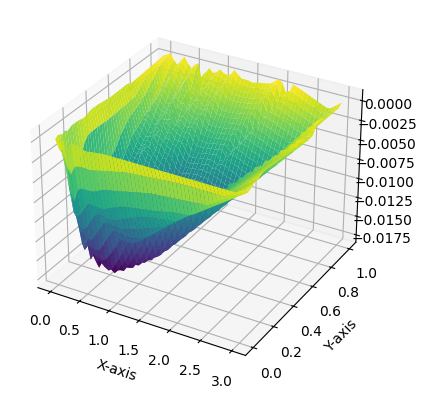

In [ ]:
# plot buckling mode again
plot_mode()